# 시계열 예측

(출처: [Kaggle](https://www.kaggle.com/code/mohamedyosef101/energy-consumption-time-series-forecasting))

(참고 문헌: [Rob J Hyndman](https://otexts.com/fpp3/))



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# customize the style
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_rows = 12

# load the data
df = pd.read_csv('AEP_hourly2.csv')
df.head()

,Datetime,AEP_MW
0,2013-01-01 00:00:00,14734.00000
1,2013-12-31 01:00:00,15128.00000
2,2013-12-31 02:00:00,14886.00000
3,2013-12-31 03:00:00,14831.00000
4,2013-12-31 04:00:00,14873.00000


## 시계열 데이터 탐색

In [2]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

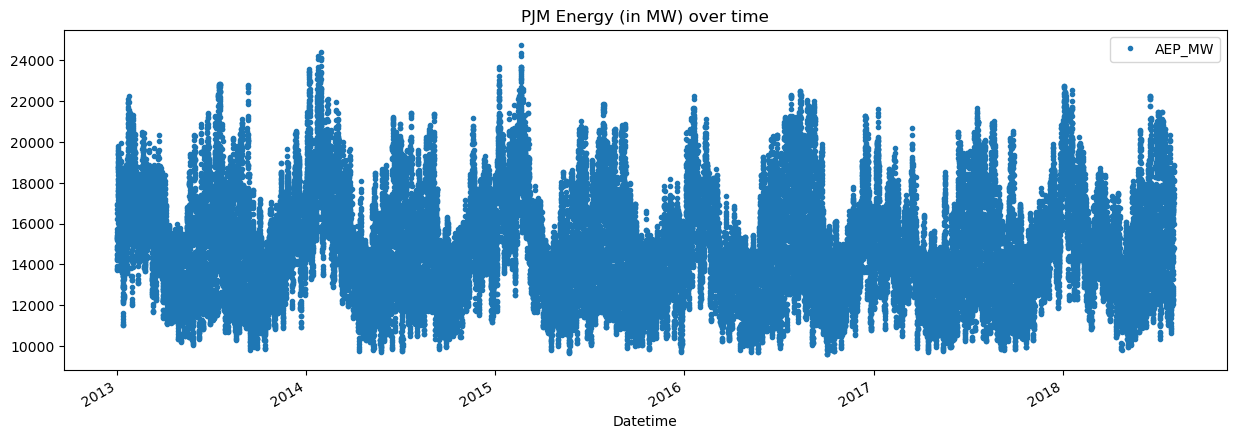

In [3]:
df.plot(style='.',
        figsize=(15, 5),
        title='PJM Energy (in MW) over time')
plt.show()

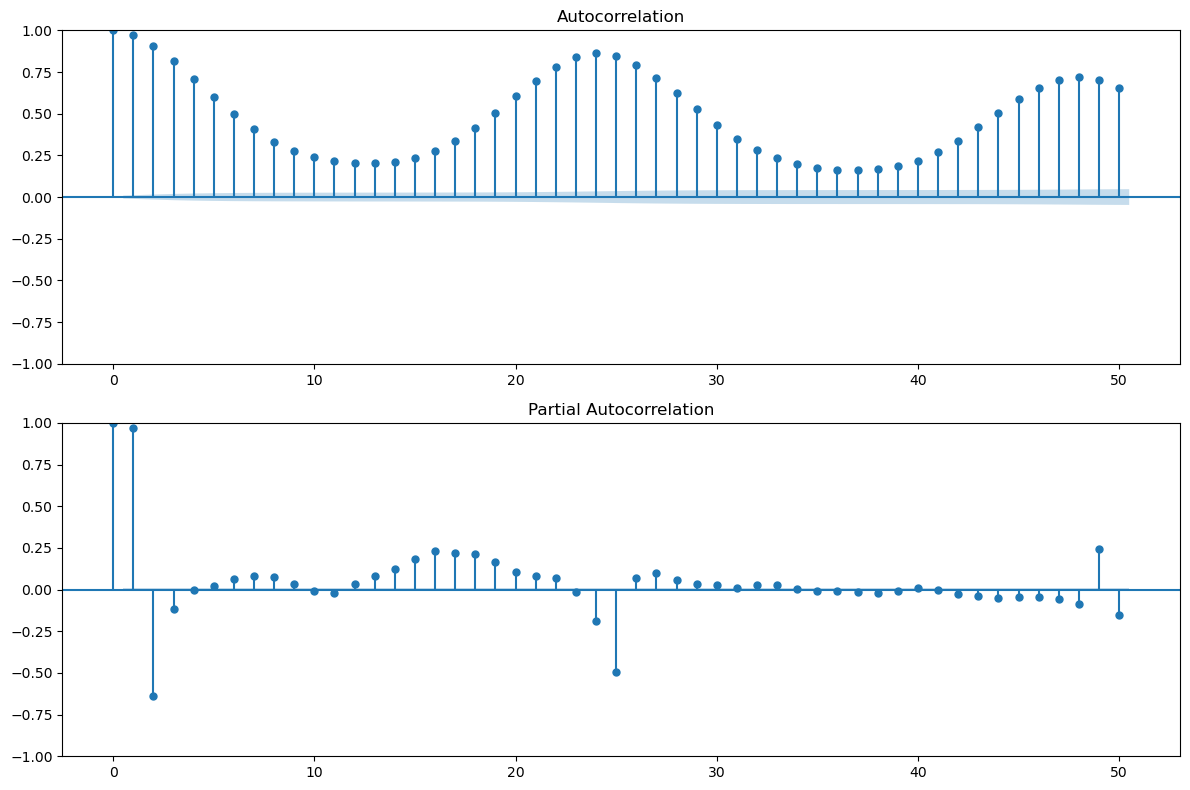

In [4]:
# ACT, PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df, ax=ax1, lags=50)
plot_pacf(df, ax=ax2, lags=50)
plt.tight_layout()
plt.show()

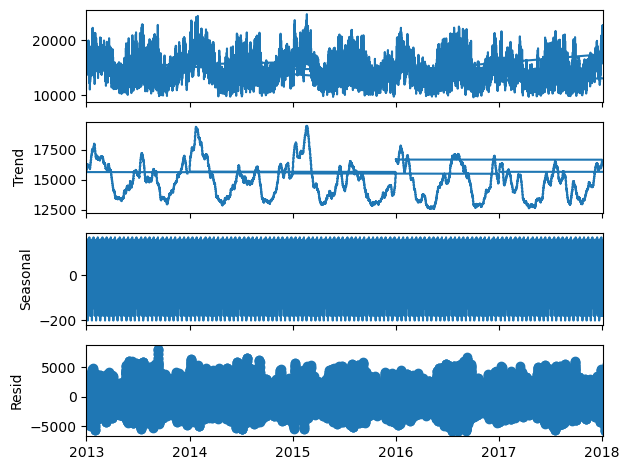

In [5]:
# 시계열 분해
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='additive', period=365)
result.plot()
plt.tight_layout()
plt.show()

## 모델링

In [6]:
# 시계열 데이터의 train/test 분할
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

In [7]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Naive 모델
naive_forecast = test.shift(1)
naive_rmse = sqrt(mean_squared_error(test[1:], naive_forecast[1:]))
print(f"Naive 모델 RMSE: {naive_rmse}")

Naive 모델 RMSE: 593.663551017545


In [8]:
# ARIMA 모델
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()
arima_forecast = model_fit.forecast(steps=len(test))
arima_rmse = sqrt(mean_squared_error(test, arima_forecast))
print(f"ARIMA 모델 RMSE: {arima_rmse}")

NameError: name 'ARIMA' is not defined

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# LSTM 모델
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X_train, y_train = create_dataset(train, train, time_steps)
X_test, y_test = create_dataset(test, test, time_steps)

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=0)

lstm_forecast = model.predict(X_test)
lstm_rmse = sqrt(mean_squared_error(y_test, lstm_forecast))
print(f"LSTM 모델 RMSE: {lstm_rmse}")

In [ ]:
# 결과 시각화
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label='실제 값')
plt.plot(test.index[1:], naive_forecast[1:], label='Naive 예측')
plt.plot(test.index, arima_forecast, label='ARIMA 예측')
plt.plot(test.index[time_steps:], lstm_forecast, label='LSTM 예측')
plt.legend()
plt.title('모델 예측 비교')
plt.show()